# Part 3c - Modelling with Larger Train Dataset
- [Pre-processing](#Pre-processing)
- [Modelling](#Modelling)
- [Conclusion](#Conclusion)
- [Recommendation](#Recommendation)
- [Future Improvements](#Future-Improvements)

## Import Libraries

In [3]:
# Basic imports
import pandas as pd
import numpy as np
from numpy import arange


# Time
import time
from datetime import datetime

# Visualisation 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import collections
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data Processing 
import re
import string
import nltk


# Scikit-learn
from sklearn import ensemble, preprocessing
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline

# Vectorizing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling - Basics
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# Modelling - Classification metrics
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import plot_roc_curve, roc_auc_score

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)
pd.set_option('display.width', None)

## Load Data

In [4]:
df = pd.read_csv('../data/final_clean_df.csv')

In [5]:
df.head()

,vaers_id,age_yrs,sex,symptom_text,hospdays,recovd,numdays,v_adminby,other_meds,history,form_vers,er_ed_visit,allergies,vax_type,vax_manu,vax_dose_series,vax_route,vax_site,vax_name,serious,clean_symptom_text,clean_other_meds,clean_history,clean_allergies
0,916612.0,71.0,F,Left side of face became numb including to beh...,0.0,U,0.0,PVT,levothyroxine mcg day estradiol mg day,Graves Disease,2.0,0.0,penicillin toradol methimazole,COVID19,MODERNA,0,IM,LA,COVID19 (COVID19 (MODERNA)),0,"['left', 'side', 'face', 'became', 'numb', 'in...","['levothyroxine', 'mcg', 'day', 'estradiol', '...","['graf', 'disease']","['penicillin', 'toradol', 'methimazole']"
1,916641.0,44.0,F,Vertigo every evening when lying down and ever...,0.0,N,0.0,PVT,multivitamin D baby aspirin,none,2.0,0.0,latex sulfa drugs,COVID19,MODERNA,0,IM,RA,COVID19 (COVID19 (MODERNA)),0,"['vertigo', 'every', 'evening', 'lying', 'ever...","['multivitamin', 'baby', 'aspirin']",[],"['latex', 'sulfa', 'drug']"
2,916702.0,70.0,F,body aches and stomach ache,0.0,N,31.0,PVT,Triamterene HCTZ Montelukast Celecoxib Aller T...,asthma when I get a cold,2.0,0.0,too much cordosone,COVID19,MODERNA,0,SYR,UN,COVID19 (COVID19 (MODERNA)),0,"['body', 'ache', 'stomach', 'ache']","['triamterene', 'hctz', 'montelukast', 'celeco...","['asthma', 'get', 'cold']","['much', 'cordosone']"
3,917195.0,47.0,F,H a diarrhea SEVERE joint pain all through bo...,0.0,N,0.0,PVT,None,Serious episode of covid,2.0,0.0,None,COVID19,MODERNA,0,UN,RA,COVID19 (COVID19 (MODERNA)),0,"['h', 'diarrhea', 'severe', 'joint', 'pain', '...",[],"['serious', 'episode']",[]
4,917195.0,47.0,F,H a diarrhea SEVERE joint pain all through bo...,0.0,N,0.0,PVT,None,Serious episode of covid,2.0,0.0,None,COVID19,MODERNA,0,UN,RA,COVID19 (COVID19 (MODERNA)),0,"['h', 'diarrhea', 'severe', 'joint', 'pain', '...",[],"['serious', 'episode']",[]


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536690 entries, 0 to 536689
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   vaers_id            536690 non-null  float64
 1   age_yrs             536690 non-null  float64
 2   sex                 536690 non-null  object 
 3   symptom_text        536690 non-null  object 
 4   hospdays            536690 non-null  float64
 5   recovd              536690 non-null  object 
 6   numdays             536690 non-null  float64
 7   v_adminby           536690 non-null  object 
 8   other_meds          383513 non-null  object 
 9   history             380085 non-null  object 
 10  form_vers           536690 non-null  float64
 11  er_ed_visit         536690 non-null  float64
 12  allergies           348819 non-null  object 
 13  vax_type            536690 non-null  object 
 14  vax_manu            536690 non-null  object 
 15  vax_dose_series     536690 non-nul

# Pre-processing

### Splitting the Data

For this iteration, we will be using a larger train dataset as compared to our baseline model (80% as train dataset).

In [10]:
X = df['clean_symptom_text']
y = df['serious']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, 
                                                    random_state=200, stratify=y)

# Modelling

Since Logistic Regression and Multinomial Naive Bayes were the best performers from the past 2 runs, we will be using these models with a larger train dataset to improve accuracy and F1 score.

#### Vectorization
* Count Vectorizer (CVEC)
* Term Frequency–Inverse Document Frequency Vectorizer (TFIDF)

#### Modelling
* Logistic Regression
* Naive Bayes - Multinomal


In [11]:
# Create empty results dataframe
df_results = pd.DataFrame(
    columns = [
        'Model No.',
        'Word Vectorizer',
        'Classifier',
        #'Cross-validated ROC AUC Score',
        'CV Score (train)',
        'Accuracy (train)',
        'Accuracy (test)',
        'Recall (test)', 
        'F1 score (test)',
        'Specificity (test)',
        'Precision (test)',
    ]
)

In [12]:
# Create function to run pipe and print results
def run_grid(X_train, X_test, y_train, y_test):

    
    # Instantiate GridSearchCV
    gs = GridSearchCV(
        pipe, 
        param_grid = params, 
        cv = 5,
        verbose = 1
    )

    # Fit model
    gs.fit(X_train, y_train)

    # Confusion matrix
    y_pred = gs.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    plot_confusion_matrix(gs, 
                  X_test, y_test, 
                  cmap='RdPu', 
                  values_format='d',
                  display_labels=['non-serious', 'serious']
                 );

    
    # Find current length of df_results
    length = len(df_results)
    
    # Store results in new_row
    new_row = [{
        'Model No.' : length + 1,
        'Word Vectorizer' : pipe.steps[0][1],
        'Classifier' : pipe.steps[1][1],
        #'Cross-validated ROC AUC Score' : round(gs.roc_auc_score(X_test, y_test), 3),
        'CV Score (train)' : round(gs.best_score_, 3),
        'Accuracy (train)': round(gs.score(X_train, y_train), 3),
        'Accuracy (test)' : round(gs.score(X_test, y_test), 3),
        'Recall (test)' : round (tp/(tp+fn), 3), 
        'F1 score (test)': round((tp/(tp+(fp+fn)/2)), 3),
        'Specificity (test)' : round (tn/(tn+fp), 3),
        'Precision (test)' : round (tp/(tp+fp), 3),
    }]
    # Print best parameters from GridSearchCV
    print('Best Parameters:', gs.best_params_)
    
    return new_row

### Logistic Regression

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'cvec__max_features': 20000, 'cvec__min_df': 10, 'cvec__ngram_range': (2, 2), 'logit__C': 1}
CPU times: user 37min 18s, sys: 3min 2s, total: 40min 20s
Wall time: 25min 57s


Text(0.5, 1.0, 'CVEC Logistic Regression')

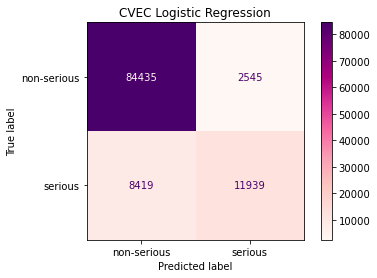

In [13]:
%%time

# Instantiate CountVectorizer() and LogisticRegressionCV()
cvec = CountVectorizer()
logit = LogisticRegression()

pipe = Pipeline([
    ('cvec', cvec),
    ('logit', logit)])

params = {
    'cvec__max_features': [5000, 10000, 20000],
    'cvec__ngram_range': [(2,2)], 
    'cvec__min_df': [10],
    #'cvec__ngram_range': [(1,1), (1,2), (1,3)],     
    'logit__C': [0.1, 1, 10],} 
    #'logit__penalty': ['l1', 'l2', 'none']}


new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
plt.title('CVEC Logistic Regression');

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'logit__C': 10, 'tvec__max_features': 20000, 'tvec__min_df': 10, 'tvec__ngram_range': (2, 2)}
CPU times: user 37min 58s, sys: 3min 6s, total: 41min 4s
Wall time: 25min 30s


Text(0.5, 1.0, 'TVEC Logistic Regression')

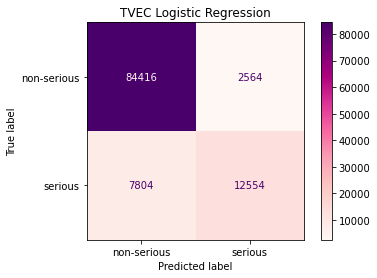

In [14]:
%%time

# Instantiate TfidfVectorizer() and LogisticRegressionCV()
tvec = TfidfVectorizer()
logit = LogisticRegression()

pipe = Pipeline([
    ('tvec', tvec),
    ('logit', logit)])

params = {
    'tvec__max_features': [5000, 10000, 20000],
    'tvec__ngram_range': [(2,2)],
    'tvec__min_df': [10],
    #'tvec__ngram_range': [(1,1), (1,2), (1,3)],    
    'logit__C': [0.1, 1, 10],} 
    #'logit__penalty': ['l1', 'l2', 'none']}


new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
plt.title('TVEC Logistic Regression');

In [15]:
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Recall (test),F1 score (test),Specificity (test),Precision (test)
0,1,CountVectorizer(),LogisticRegression(),0.898,0.913,0.898,0.586,0.685,0.971,0.824
0,2,TfidfVectorizer(),LogisticRegression(),0.902,0.914,0.903,0.617,0.708,0.971,0.830


**Observations:**

The model has hit our target of 0.7 for accuracy and F1 score for tvec but not cvec.

The model has a great train and test accuracy score of around 0.9 with low overfitting. The model using tvec also hits our target F1 score of 0.7 indicating a good balance between prioritizing recall and precision. 

### Multinomial Naive Bayes

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'cvec__max_features': 40000, 'cvec__min_df': 10, 'cvec__ngram_range': (2, 2), 'nb__alpha': 0.5, 'nb__fit_prior': True}
CPU times: user 28min 53s, sys: 23.3 s, total: 29min 16s
Wall time: 29min 21s


Text(0.5, 1.0, 'CVEC Naive Bayes')

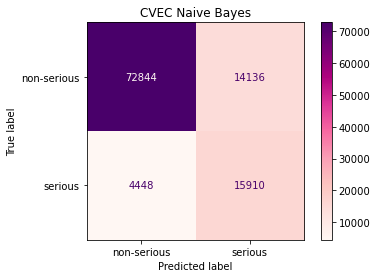

In [16]:
%%time

# Instantiate CountVectorizer() and MultinomialNB()
cvec = CountVectorizer()
nb = MultinomialNB()

pipe = Pipeline([
    ('cvec', cvec),
    ('nb', nb)])

params = {
    'cvec__max_features': [10000, 20000, 40000],
    'cvec__ngram_range': [(2,2)], 
    'cvec__min_df': [10],
    'nb__alpha': np.linspace(0.5, 1.5, 2),
    'nb__fit_prior': [True, False]
}

new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
plt.title('CVEC Naive Bayes');

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'nb__alpha': 1.5, 'nb__fit_prior': True, 'tvec__max_features': 40000, 'tvec__min_df': 10, 'tvec__ngram_range': (2, 2)}
CPU times: user 28min 5s, sys: 19.5 s, total: 28min 24s
Wall time: 28min 25s


Text(0.5, 1.0, 'TF-IDF Naive Bayes')

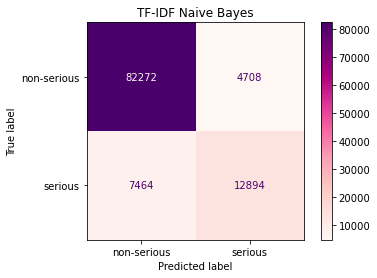

In [17]:
%%time

# Instantiate TfidfVectorizer() and MultinomialNB()
tvec = TfidfVectorizer()
nb = MultinomialNB()

pipe = Pipeline([
    ('tvec', tvec),
    ('nb', nb)
])

params = {
    'tvec__max_features': [10000, 20000, 40000],
    'tvec__ngram_range': [(2,2)], 
    'tvec__min_df': [10],
    'nb__alpha': np.linspace(0.5, 1.5, 2),
    'nb__fit_prior': [True, False]}

new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
plt.title('TF-IDF Naive Bayes');

In [18]:
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Recall (test),F1 score (test),Specificity (test),Precision (test)
0,1,CountVectorizer(),LogisticRegression(),0.898,0.913,0.898,0.586,0.685,0.971,0.824
0,2,TfidfVectorizer(),LogisticRegression(),0.902,0.914,0.903,0.617,0.708,0.971,0.830
0,3,CountVectorizer(),MultinomialNB(),0.827,0.830,0.827,0.782,0.631,0.837,0.530
0,4,TfidfVectorizer(),MultinomialNB(),0.887,0.890,0.887,0.633,0.679,0.946,0.733


**Observations:**

The model has hit our target of 0.7 for accuracy but not for F1 score.

The model has test and train accuracy of 0.8 and F1 score of 0.6. With the model using cvec has a higher recall indicating that it is misclassifying serious AE, while the opposite is true for the model using tvec.

## Comparison of Models

| Model No. | SMOTE? | Word Vectorizer | Classifier | CV Score (train) | Accuracy (train) | Accuracy (test) | Recall (test) | F1 score (test) | Specificity (test) | Precision (test) |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| 1 | No | CountVectorizer  | LogisticRegression  | 0.883 | 0.95 | 0.885 | 0.562 | 0.649 | 0.96 | 0.768 |
| 2 | No | TfidfVectorizer  | LogisticRegression  | 0.887 | 0.948 | 0.889 | 0.584 | 0.667 | 0.961 | 0.776 |
| 3 | No | CountVectorizer  | MultinomialNB  | 0.823 | 0.847 | 0.825 | 0.761 | 0.623 | 0.84 | 0.527 |
| 4 | No | TfidfVectorizer  | MultinomialNB  | 0.882 | 0.899 | 0.884 | 0.514 | 0.628 | 0.971 | 0.806 |
| 5 | No | CountVectorizer  | RandomForestClassifier  | 0.871 | 0.98 | 0.872 | 0.584 | 0.634 | 0.939 | 0.693 |
| 6 | No | TfidfVectorizer  | RandomForestClassifier  | 0.881 | 0.98 | 0.883 | 0.542 | 0.637 | 0.963 | 0.773 |
| 7 | No | CountVectorizer  | AdaBoostClassifier  | 0.861 | 0.861 | 0.86 | 0.333 | 0.473 | 0.983 | 0.819 |
| 8 | No | TfidfVectorizer  | AdaBoostClassifier  | 0.861 | 0.865 | 0.861 | 0.348 | 0.487 | 0.981 | 0.81 |
| 19 | No | CountVectorizer  | SVC  | 0.846 | 0.896 | 0.849 | 0.287 | 0.419 | 0.981 | 0.777 |
| 10 | No | TfidfVectorizer  | SVC  | 0.881 | 0.971 | 0.885 | 0.464 | 0.604 | 0.983 | 0.865 |
| 11 | Yes | CountVectorizer  | LogisticRegression  | 0.815 | 0.938 | 0.816 | 0.71 | 0.594 | 0.841 | 0.511 |
| 12 | Yes | TfidfVectorizer  | LogisticRegression  | 0.837 | 0.933 | 0.839 | 0.732 | 0.633 | 0.864 | 0.558 |
| 13 | Yes | CountVectorizer  | MultinomialNB  | 0.826 | 0.854 | 0.833 | 0.753 | 0.631 | 0.851 | 0.542 |
| 14 | Yes | TfidfVectorizer  | MultinomialNB  | 0.829 | 0.86 | 0.831 | 0.761 | 0.63 | 0.847 | 0.538 |
| 15 | Yes | CountVectorizer  | RandomForestClassifier  | 0.797 | 0.952 | 0.803 | 0.652 | 0.557 | 0.839 | 0.486 |
| 16 | Yes | TfidfVectorizer  | RandomForestClassifier  | 0.829 | 0.963 | 0.834 | 0.682 | 0.609 | 0.87 | 0.55 |
| 17 | Yes | CountVectorizer  | AdaBoostClassifier  | 0.616 | 0.624 | 0.621 | 0.803 | 0.446 | 0.578 | 0.308 |
| 18 | Yes | TfidfVectorizer  | AdaBoostClassifier  | 0.584 | 0.594 | 0.588 | 0.847 | 0.438 | 0.528 | 0.296 |
| 19 | Yes | CountVectorizer  | SVC  | 0.694 | 0.799 | 0.704 | 0.763 | 0.494 | 0.69 | 0.365 |
| 20 | Yes | TfidfVectorizer  | SVC  | 0.855 | 0.971 | 0.863 | 0.65 | 0.643 | 0.913 | 0.636 |
| 21 | No | CountVectorizer  | LogisticRegression (larger train dataset) | 0.898 | 0.913 | 0.898 | 0.586 | 0.685 | 0.971 | 0.824 |
| 22 | No | TfidfVectorizer  | LogisticRegression (larger train dataset) | 0.902 | 0.914 | 0.903 | 0.617 | 0.708 | 0.971 | 0.83 |
| 23 | No | CountVectorizer  | MultinomialNB (larger train dataset) | 0.827 | 0.83 | 0.827 | 0.782 | 0.631 | 0.837 | 0.53 |
| 24 | No | TfidfVectorizer  | MultinomialNB (larger train dataset) | 0.887 | 0.89 | 0.887 | 0.633 | 0.679 | 0.946 | 0.733 |

Out of all the models tested, the best performing model is Logistic Regression using TF-IDF vectorizer on a train/test split of 80/20 (Model 22). It has the highest test accuracy of 0.903 and F1 score of 0.708. It is performing better than our baseline Logistic Regression model with Count Vectorizer (with a smaller training set). Hence, we will use Logistic Regression using TF-IDF vectorizer on a train/test split of 80/20 as the chosen model.



With a test accuracy of 0.904 in predicting serious AE, this model has met the target set of 0.7. The train accuracy of 0.914 indicates that the model is not overfitted to the training dataset. The 5-fold cross-validated score of 0.902 shows that the test score is a reliable measure of the model performance. The F1 score of 0.709 has also met our target of 0.7.



## Final Model

In [56]:
%%time
# Create and fit the final selected model

# Best Parameters: {'logit__C': 10, 
#                   'tvec__max_features': 20000, 
#                   'tvec__min_df': 10, 
#                   'tvec__ngram_range': (2, 2)}
    
pipe = Pipeline([
    ('tvec', TfidfVectorizer(max_features=20000, ngram_range=(2,2))),
    ('logit', LogisticRegression(C=10))])

pipe.fit(X_train, y_train)

# Print results
print(f'Train score (Accuracy): {pipe.score(X_train, y_train):.3f}, Test score (Accuracy): {pipe.score(X_test, y_test):.3f}')
print(f'Recall: {tp/(tp+fn):.3f}, F1 score (test): {tp/(tp+(fp+fn)/2):.3f}, Specificity: {tn/(tn+fp):.3f}, Precision: {tp/(tp+fp):.3f}')

Train score (Accuracy): 0.913, Test score (Accuracy): 0.904
Recall: 0.617, F1 score (test): 0.709, Specificity: 0.971, Precision: 0.834
CPU times: user 1min 29s, sys: 9.19 s, total: 1min 39s
Wall time: 1min 2s


#### Confusion Matrix
The confusion matrix allows us to evaluate the performance of a classification model (in this case Logistic Regression), as it allows a comparison of the actual target label against the predicted label. This gives us a hoslistic view of how well the model is performing and what kind of errors it is making.

<Figure size 432x432 with 0 Axes>

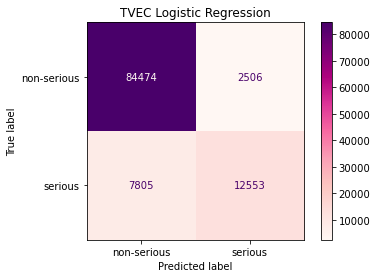

In [52]:
plt.figure(figsize=(6,6))        

# Confusion Matrix
y_pred = pipe.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()


plot_confusion_matrix(pipe, 
                      X_test, y_test, 
                      cmap='RdPu', 
                      values_format='d',
                      display_labels=['non-serious', 'serious']
                     );
plt.title('TVEC Logistic Regression');

**Observations:**
* From the confusion matrix, we see the model misclassifying serious as non-serious accounting for the lower recall score.
* Conversely, we see that the model is misclassifying only a handful of non-serious AE as serious, which is seen in the high precision score.

#### ROC-AUC Curve
The ROC (receiver operating characteristic) curve AUC (area under the curve) enables us to visualise the performance of a classification model. ROC is a probability curve and AUC represents the degree of separability, meaning how well the model is able to distinguish between the different classes. The higher the AUC, the better the model is at distinguishing between serious and non-serious AE.

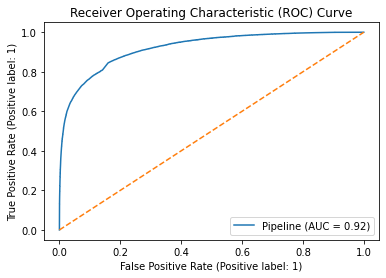

In [26]:
# ROC curve
plot_roc_curve(pipe, X_test, y_test)

# add worst case scenario line
plt.plot([0,1], [0,1], label = "baseline", linestyle = "--")

# add title
plt.title('Receiver Operating Characteristic (ROC) Curve');

**Observations:**
* The AUC of 0.92 is indicates that model is able to distinguish between serious and non-serious AE 92% of the time.

### Features of importance

In [27]:
# Obtain coefficients from logit model
coef = pipe.named_steps['logit'].coef_.flatten()

# Obtain feature names from TF-IDF vectorizer
features = pipe.named_steps['tvec'].get_feature_names()

# Create dataframe of features and their coefficients
df_coef = pd.DataFrame(zip(features, coef), 
                       columns = ["Features", "Coefficient"]
                      ).sort_values('Coefficient', 
                                    ascending = False)

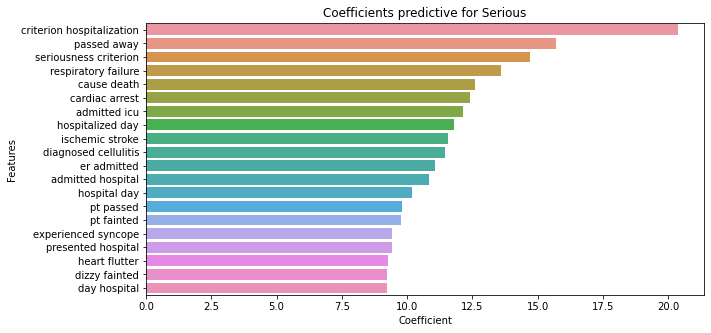

In [57]:
# Plot 20 highest coefficients
plt.figure(figsize=(10,5))
ax = sns.barplot(x = 'Coefficient', y = 'Features', data = df_coef.head(20))
ax.set_title(f"Coefficients predictive for Serious")
ax.set_xlabel("Coefficient")
ax.set_ylabel("Features");

In [53]:
df_coef.head(10)

,Features,Coefficient
3407,criterion hospitalization,20.356525
12751,passed away,15.721195
15240,seriousness criterion,14.718081
14718,respiratory failure,13.585268
2580,cause death,12.585968
2495,cardiac arrest,12.397994
358,admitted icu,12.133203
8179,hospitalized day,11.795052
9183,ischemic stroke,11.559897
4108,diagnosed cellulitis,11.450317


**Observations:**
The largest coefficients represent words that a predictive of class 1, which is serious AE. We see phrases that pertain to various serious criterion such as 'criterion hospitalization', 'admitted icu' and 'hospitalized day' for hospitalisation criterion. 'Passed away' and 'cause death' reflect the death criterion, with 'respiratory failure', 'cardiac arrest', 'ischemic stroke' and 'diagnosed cellulitis falling into other important medical event criterion.

Since the words with the highest coefficient seem to represent serious AE rather well, it is no surprise that the misclassification by the model of non-serious AE as serious is rather low with a precision of 0.834.

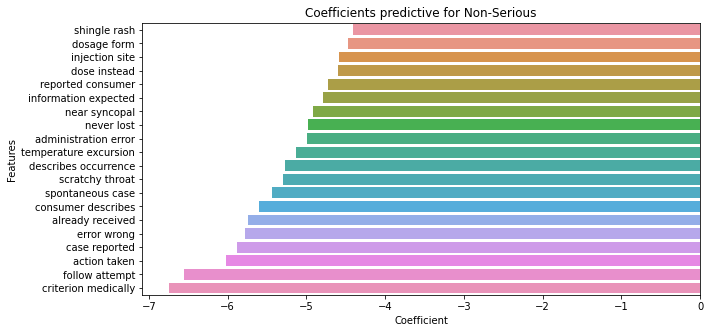

In [58]:
# Plot 20 lowest coefficients
plt.figure(figsize=(10,5))
ax = sns.barplot(x = 'Coefficient', y = 'Features', data = df_coef.tail(20))
ax.set_title(f"Coefficients predictive for Non-Serious")
ax.set_xlabel("Coefficient")
ax.set_ylabel("Features");

In [31]:
df_coef.tail(10)

,Features,Coefficient
4013,describes occurrence,-5.273708
15068,scratchy throat,-5.291882
16354,spontaneous case,-5.431451
3128,consumer describes,-5.594512
505,already received,-5.743912
5194,error wrong,-5.782146
2567,case reported,-5.878551
230,action taken,-6.013667
6810,follow attempt,-6.558454
3408,criterion medically,-6.748006


**Observations:**
The lowest coefficients represent words that a predictive of class 2, which is non-serious AE. The phrases seems to be more general and less specific as compared to the largest coefficients. Phrases like 'describes occurrence', 'spontaneous case', 'case reported', 'action taken' and 'follow attempt' would be present in both serious and non-serious cases.

Since the words with the lowest coefficient seem to be rather generic, we find the model misclassifying some serious AE as non-serious with a recall of 0.617.

## Conclusion & Recommendations

Overall, the chosen model is succesful in meeting the requirements by the problem statement. With a test accuracy of 0.904, train accuracy of 0.914 and F1 score of 0.709. The difference between the train and test accuracy of 0.01 indicates that the model is not overfitted to the training dataset. The 5-fold cross-validated score of 0.902 shows that the test score is a reliable measure of the model performance. 

#### Recommendations
Since our model is able to accuracy classify serious AE, it could be implemented as a preliminary screening tool for all incoming AE reports, to get an initial seriousness classification. This would help to enable serious reports to get expedited and processed more quickly, enabling signal detection to occur more efficiently.

## Future Improvements

#### Obtain further data to expand scope of model
Since there is a low rate of reporting AE in Singapore, it would be helpful to look into expanding this model to be able to classify between an AE report vs non-AE report. With such a model, it would be possible to try to obtain AE reports from retrospectively looking at electronic medical reports to sieve out potential AE instead of relying passively for people to report cases.

#### Use of deep learning techniques through neural networks
As neural networks are able to learn and model non-linear and complex relationships, it could possibly be used to classify reports more efficiently as it would be able to distinguish nuance difference through optimisation of the layers. 

#### Incorporate use of non-text columns into model
The use of non-text data could be included into training of the model to help produce a more robust model.




